# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

### Plan so far...

#### Dependent Variable:

    - Price

#### Explanatory Variables:

    - Keep: ['bedrooms',
             'bathrooms',
             'sqft_living',
             'floors',
             'sqft_above',
             'sqft_basement',
             'sqft_living15',
             'view',
             'waterfront',
             'yr_built]
    
    - Drop: ['sqft_lot', 'sqft_lot15']
    
    - Create dummies: ['condition', 'zipcode', 'grade']
    
    - Convert to binary: ['yr_renovated']
    
    - Will have to think of a plan for latitude and longitude

In [102]:
# Thoughts for another time... so using city data instead of Zipcode dropped R2 and increased RMSE by about 20k.
# ... but it's better practice to drop the predictors by 46... 
# I suppose try it out this way for now instead of using zip - go by city

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

In [2]:
############ So at the moment, improved this copy model with making basement binary and binning bathrooms
############ then creating a dummy
############ next maybe add in month sold

#### Import and drop columns:

In [3]:
house_data = pd.read_csv('house_data_cleaned.csv')
house_data.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)
house_data.head()

,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340
1,12/9/2014,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690
2,2/25/2015,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720
3,12/9/2014,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360
4,2/18/2015,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800


#### Add month column inplace of date...

In [4]:
house_data['month'] = house_data.date.apply(lambda x: x.split('/'))
house_data['month'] = house_data.month.apply(lambda x: x[0:1])
house_data['month'] = house_data.month.apply(lambda x: str(x))
house_data['month'] = house_data.month.apply(lambda x: x.strip("[]"))
house_data['month'] = house_data.month.apply(lambda x: x.strip("''"))
house_data.month = house_data['month'].astype(int)
house_data.drop('date', axis=1, inplace=True)
house_data.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,month
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,10
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,12
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,2
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,12
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,2


#### Create dummy variables:

In [5]:
def zco(x):
    city = search.by_zipcode(x).city 
    return city if city else x  # if city is None for certain zipcodes, take advantage of the truthiness of None

In [6]:
house_data['city'] = house_data['zipcode'].apply(zco)

In [7]:
house_data['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [8]:
bins = [0,1,2,3,4,5,6,7,8]
house_data['bath_bins'] = pd.cut(house_data['bathrooms'], bins, include_lowest=True)

house_data.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,month,city,bath_bins
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,10,Seattle,"(-0.001, 1.0]"
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,12,Seattle,"(2.0, 3.0]"
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,2,Kenmore,"(-0.001, 1.0]"
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,12,Seattle,"(2.0, 3.0]"
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,2,Sammamish,"(1.0, 2.0]"


In [9]:
house_data['bath_bins'] = house_data['bath_bins'].cat.codes
house_data.bath_bins.value_counts()

2    9362
1    6432
0    3926
3    1611
4     223
5      33
6       6
7       4
Name: bath_bins, dtype: int64

In [10]:
# Drop first variable so they do not reference one another
# grade_dum = pd.get_dummies(house_data['grade'], prefix='grade_', drop_first=True)
# view_dum = pd.get_dummies(house_data['view'], prefix='view_', drop_first=True)
# zipcode_dum = pd.get_dummies(house_data['zipcode'], prefix='zipcode_', drop_first=True)
bath_dum = pd.get_dummies(house_data['bath_bins'], prefix='bath', drop_first=True)
city_dum = pd.get_dummies(house_data['city'], prefix='city', drop_first=True)
# zipcode_dum.head()

In [88]:
# Now to merge dummy columns onto our dataframe
upHouse_data = pd.concat([house_data, city_dum, bath_dum], axis=1)
upHouse_data.drop(columns=['zipcode', 'city', 'bathrooms', 'bath_bins', 'bath_6', 'bath_7'], inplace=True)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   sqft_living         21597 non-null  int64  
 3   floors              21597 non-null  float64
 4   waterfront          21597 non-null  float64
 5   view                21597 non-null  float64
 6   condition           21597 non-null  int64  
 7   grade               21597 non-null  int64  
 8   sqft_above          21597 non-null  int64  
 9   sqft_basement       21597 non-null  float64
 10  yr_built            21597 non-null  int64  
 11  yr_renovated        21597 non-null  float64
 12  lat                 21597 non-null  float64
 13  long                21597 non-null  float64
 14  sqft_living15       21597 non-null  int64  
 15  month               21597 non-null  int64  
 16  city

In [89]:
# Create a binary renovated column to determine whether the home was renovated or not
# Since the year renovated is not actionable unless we specialize in selling renovated homes from specific years
# but this way we can determine whether we should focus on renovations or not
upHouse_data['yr_renovated'] = upHouse_data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
upHouse_data.rename(columns = {"yr_renovated":"renovated"}, inplace=True)

In [90]:
upHouse_data['sqft_basement'] = upHouse_data.sqft_basement.apply(lambda x: 1 if x > 0 else 0)
upHouse_data.rename(columns = {"sqft_basement":"basement"}, inplace=True)

In [91]:
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   sqft_living         21597 non-null  int64  
 3   floors              21597 non-null  float64
 4   waterfront          21597 non-null  float64
 5   view                21597 non-null  float64
 6   condition           21597 non-null  int64  
 7   grade               21597 non-null  int64  
 8   sqft_above          21597 non-null  int64  
 9   basement            21597 non-null  int64  
 10  yr_built            21597 non-null  int64  
 11  renovated           21597 non-null  int64  
 12  lat                 21597 non-null  float64
 13  long                21597 non-null  float64
 14  sqft_living15       21597 non-null  int64  
 15  month               21597 non-null  int64  
 16  city

In [15]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.7) & (coral.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living15, sqft_above)",0.731767
"(sqft_living15, grade)",0.713867
"(long, city_Seattle)",0.709844
"(price, sqft_living)",0.701917


In [92]:
# drop squarefoot above. Maybe interaction with squarefoot living and living15
upHouse_data.drop('sqft_above', axis=1, inplace=True)

### Scaling

In [17]:
col_list = list(upHouse_data.columns)

In [27]:
#Separate data into categorical and continuous groups. 
cat_data = upHouse_data[['waterfront','renovated','basement','city_Bellevue','city_Black Diamond','city_Bothell',
                 'city_Carnation','city_Duvall','city_Enumclaw','city_Fall City','city_Federal Way','city_Issaquah',
                 'city_Kenmore','city_Kent','city_Kirkland','city_Maple Valley','city_Medina','city_Mercer Island',
                 'city_North Bend','city_Redmond','city_Renton','city_Sammamish','city_Seattle','city_Snoqualmie',
                 'city_Vashon','city_Woodinville','bath_1','bath_2','bath_3','bath_4','bath_5']]

con_data = upHouse_data.drop(cat_data, axis=1)
con_data.drop('price', axis=1, inplace=True)

1. Vanilla model - no scaling or outliers
2. Outliers/Scaled model - remove outliers, go to $790k, then scale
4. Interactions model
5. Polynomial model 
6. P-Filter Model (still need to decide)


### Now Train-Test-Split

... in preparation for our baseline model

In [133]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [134]:
X = upHouse_data[feat_cols]
y = upHouse_data['price']

In [135]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,renovated,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,3,1200,1.0,0.0,0.0,4,7,0,1969,0,...,0,0,0,0,0,0,0,0,0,0
19664,3,1920,1.0,0.0,0.0,3,8,0,2014,0,...,0,0,0,0,0,0,1,0,0,0
13949,3,1590,1.5,0.0,0.0,4,6,0,1926,0,...,0,0,0,0,0,1,0,0,0,0
15272,4,2530,3.0,0.0,2.0,3,9,1,2013,0,...,0,1,0,0,0,0,0,1,0,0
14411,3,2010,2.0,0.0,0.0,3,8,1,2014,0,...,0,0,0,0,0,0,1,0,0,0


In [129]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [136]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

In [114]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

In [115]:
len(X_train_norm)

15117

In [132]:
X_train_norm.head()

,const,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,1.0,0.0,0.06250,0.063022,0.0,0.0,0.0,0.75,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19664,1.0,0.0,0.06250,0.117692,0.0,0.0,0.0,0.50,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13949,1.0,0.0,0.06250,0.092635,0.2,0.0,0.0,0.75,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15272,1.0,0.0,0.09375,0.164009,0.8,0.0,0.5,0.50,0.6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14411,1.0,0.0,0.06250,0.124525,0.4,0.0,0.0,0.50,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [123]:
X_train_norm.set_index(y_train.index, inplace=True)

In [137]:
X_train_norm.head()

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,1.0,0.06250,0.063022,0.0,0.0,0.0,0.75,0.4,0.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19664,1.0,0.06250,0.117692,0.0,0.0,0.0,0.50,0.5,0.0,0.991304,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13949,1.0,0.06250,0.092635,0.2,0.0,0.0,0.75,0.3,0.0,0.226087,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15272,1.0,0.09375,0.164009,0.8,0.0,0.5,0.50,0.6,1.0,0.982609,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14411,1.0,0.06250,0.124525,0.4,0.0,0.0,0.50,0.5,1.0,0.991304,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [119]:
y_train.head()

4900      186000.0
19664     465000.0
13949     280000.0
15272    1120000.0
14411     550000.0
Name: price, dtype: float64

In [120]:
y_train.index

Int64Index([ 4900, 19664, 13949, 15272, 14411,  5902, 17612, 10414,  4724,
            12407,
            ...
             3650, 12059, 10224,  2699, 17489, 15969, 20055,  6224,  9328,
            11758],
           dtype='int64', length=15117)

### Vanilla Model

#### Side Note: Model Function

In [117]:
# I don't need those predictors/formulas
def training_model(predictor_cols, outcome, y_train, X_train):
    predictors = '+'.join(predictor_cols)
    formula = outcome + '~' + predictors
    model_vanilla = sm.OLS(y_train, X_train).fit()
    return model_vanilla.summary()

In [138]:
training_model(feat_cols, outcome, y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1135.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:34:40   Log-Likelihood:            -2.0418e+05
No. Observations:               15117   AIC:                         4.085e+05
Df Residuals:                   15074   BIC:                         4.088e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.919e+05   1.76e+04    -10.877      0.000   -2.26e+05   -1.57e+05
bedrooms           -8.159e+05   6.34e+04    -12.861      0.000    -9.4e+05   -6.92e+05
sqft_living         2.043e+06   4.66e+04     43.833      0.000    1.95e+06    2.13e+06
floors              8.451e+04   9751.086      8.667      0.000    6.54e+04    1.04e+05
waterfront          6.416e+05   1.89e+04     33.932      0.000    6.05e+05    6.79e+05
view                 1.82e+05   8960.401     20.311      0.000    1.64e+05       2e+05
condition           1.024e+05   1.01e+04     10.170      0.000    8.27e+04    1.22e+05
grade               8.802e+05   2.32e+04     37.872      0.000    8.35e+05    9.26e+05
basement           -6431.1203   3675.173     -1.750      0.080   -1.36e+04     772.665
yr_built           -2.011e+05   9191.514    -21.884      0.000   -2.19e+05   -1.83e+05
renovated           3.593e+04   8413.864      4.270      0.000    1.94e+04    5.24e+04
lat                  3.63e+05   1.41e+04     25.735      0.000    3.35e+05    3.91e+05
long               -4.576e+05    4.2e+04    -10.908      0.000    -5.4e+05   -3.75e+05
sqft_living15       1.605e+05   2.03e+04      7.893      0.000    1.21e+05       2e+05
month              -3.999e+04   5152.380     -7.761      0.000   -5.01e+04   -2.99e+04
city_Bellevue       2.114e+05   1.18e+04     17.976      0.000    1.88e+05    2.34e+05
city_Black Diamond  1.354e+05   2.37e+04      5.705      0.000    8.89e+04    1.82e+05
city_Bothell       -1.393e+05   1.95e+04     -7.143      0.000   -1.77e+05   -1.01e+05
city_Carnation      4.925e+04   2.64e+04      1.866      0.062   -2489.345    1.01e+05
city_Duvall         -4.83e+04   2.24e+04     -2.160      0.031   -9.21e+04   -4478.730
city_Enumclaw       1.716e+05    1.8e+04      9.533      0.000    1.36e+05    2.07e+05
city_Fall City      1.333e+05   2.75e+04      4.841      0.000    7.93e+04    1.87e+05
city_Federal Way   -7.547e+04   1.14e+04     -6.625      0.000   -9.78e+04   -5.31e+04
city_Issaquah       9.555e+04   1.39e+04      6.850      0.000    6.82e+04    1.23e+05
city_Kenmore       -1.617e+05   1.76e+04     -9.161      0.000   -1.96e+05   -1.27e+05
city_Kent          -5869.1212   9784.253     -0.600      0.549    -2.5e+04    1.33e+04
city_Kirkland       3.719e+04   1.35e+04      2.764      0.006    1.08e+04    6.36e+04
city_Maple Valley   8.188e+04   1.33e+04      6.157      0.000    5.58e+04    1.08e+05
city_Medina         8.837e+05    3.2e+04     27.599      0.000    8.21e+05    9.47e+05
city_Mercer Island  3.108e+05    1.6e+04     19.379      0.000    2.79e+05    3.42e+05
city_North Bend     1.825e+05   2.36e+04      7.748      0.000    1.36e+05    2.29e+05
city_Redmond        4.326e+04   1.43e+04      3.034      0.002    1.53e+04    7.12e+04
city_Renton         -1.35e+04   9969.0

In [252]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

In [139]:
model_vanilla = sm.OLS(y_train, X_train_norm).fit()

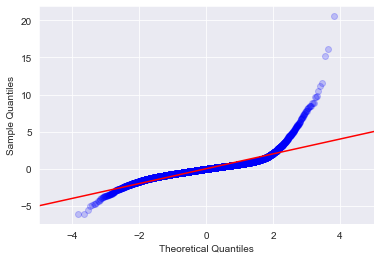

In [140]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_vanilla.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [141]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_vanilla.predict(X_train_norm)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_vanilla.predict(X_test_norm)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
rmse_vanilla = rmse_test


Train RMSE: 177703.18334308348 
 Test RMSE: 188904.67812616914
Percent change:  6.303


In [256]:
# Our test model is actually not far off, especially for the vanilla model.
# That being said, RMSE seems high. I think we can bring this down...
# especially by removing outliers and collinearity

### Model 2: Removing Outliers

In [257]:
# Going to remove outliers based on 2 standard deviations (95%)
# This is because our business focus is not on the most expensive or the cheapest homes.
# So in order to improve our model's prediction for relevant prices, we'll narrow our scope
# Down the line, I'd like to look at zipcodes and schools/bus stop data to see if that correlates with price
# If so, maybe we focus on those homes.
# Otherwise, let's see how renovations predicts pricing

Based on the results below for standard deviation of pricing, it would be inaccurate to filter our training and testing sets based on their own respective standard deviation since they will differ.

Therefore, to maintain consistency without training the original training set, we will filter both training and testing data based on 2 standard deviations from the mean from the overall dataset. This is effectively the same results as removing the pricing outliers before train_test_split.

In [258]:
# Here is our code for filtering the training set based on 2 std from full dataset
# We can see the before and after to verify that outliers have been trimmed
mean_price = np.mean(upHouse_data.price, axis=0)
sd_price = np.std(upHouse_data.price, axis=0)

final_y_train_list = [y for y in y_train if (y > mean_price - 2 * sd_price)]
final_y_train_list = [y for y in final_y_train_list if (y < mean_price + 2 * sd_price)]
y_train_2std = pd.Series(final_y_train_list)

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

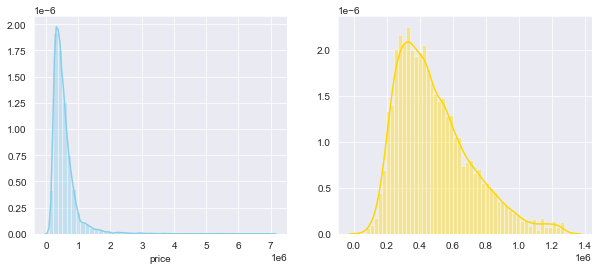

In [259]:
f, axes = plt.subplots(1, 2, figsize=(10,4));
sns.distplot(y_train, color="skyblue", ax=axes[0])
sns.distplot(y_train_2std, color="gold", ax=axes[1]);

In [142]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
upHouse_data_2std = upHouse_data[np.abs(stats.zscore(upHouse_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(upHouse_data.index.difference(upHouse_data_2std.index)))
len(upHouse_data_2std)

841


20756

In [143]:
X = upHouse_data_2std[feat_cols]
y = upHouse_data_2std['price']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [74]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [145]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

In [146]:
training_model(feat_cols, outcome, y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     1081.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:53   Log-Likelihood:            -1.8931e+05
No. Observations:               14529   AIC:                         3.787e+05
Df Residuals:                   14486   BIC:                         3.790e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.409e+05   1.13e+04    -12.486      0.000   -1.63e+05   -1.19e+05
bedrooms           -3.088e+05   4.09e+04     -7.559      0.000   -3.89e+05   -2.29e+05
sqft_living         6.288e+05   1.74e+04     36.101      0.000    5.95e+05    6.63e+05
floors              8.886e+04   6216.696     14.294      0.000    7.67e+04    1.01e+05
waterfront          1.486e+05   1.82e+04      8.183      0.000    1.13e+05    1.84e+05
view                1.258e+05   6127.998     20.529      0.000    1.14e+05    1.38e+05
condition           9.378e+04   6395.374     14.664      0.000    8.12e+04    1.06e+05
grade               5.926e+05   1.36e+04     43.635      0.000    5.66e+05    6.19e+05
basement            3662.9783   2346.674      1.561      0.119    -936.803    8262.759
yr_built           -1.714e+05   5914.599    -28.981      0.000   -1.83e+05    -1.6e+05
renovated           3.239e+04   5605.801      5.778      0.000    2.14e+04    4.34e+04
lat                 3.129e+05   8860.616     35.310      0.000    2.96e+05     3.3e+05
long                -2.92e+05   2.69e+04    -10.874      0.000   -3.45e+05   -2.39e+05
sqft_living15        2.48e+05   1.36e+04     18.221      0.000    2.21e+05    2.75e+05
month              -2.456e+04   3242.511     -7.573      0.000   -3.09e+04   -1.82e+04
city_Bellevue       1.655e+05   7401.618     22.361      0.000    1.51e+05     1.8e+05
city_Black Diamond  1.417e+05   1.43e+04      9.904      0.000    1.14e+05     1.7e+05
city_Bothell       -9.322e+04   1.23e+04     -7.588      0.000   -1.17e+05   -6.91e+04
city_Carnation      3.612e+04   1.62e+04      2.234      0.025    4427.379    6.78e+04
city_Duvall        -4.197e+04   1.35e+04     -3.100      0.002   -6.85e+04   -1.54e+04
city_Enumclaw       1.204e+05   1.09e+04     11.026      0.000     9.9e+04    1.42e+05
city_Fall City        1.1e+05   1.78e+04      6.170      0.000     7.5e+04    1.45e+05
city_Federal Way   -5.385e+04   7056.607     -7.631      0.000   -6.77e+04      -4e+04
city_Issaquah       1.172e+05   8725.580     13.430      0.000       1e+05    1.34e+05
city_Kenmore       -1.089e+05   1.09e+04     -9.998      0.000    -1.3e+05   -8.76e+04
city_Kent          -1.058e+04   6045.464     -1.751      0.080   -2.24e+04    1265.550
city_Kirkland       4.597e+04   8405.168      5.469      0.000    2.95e+04    6.24e+04
city_Maple Valley   6.004e+04   8277.933      7.253      0.000    4.38e+04    7.63e+04
city_Medina         4.722e+05   3.96e+04     11.918      0.000    3.95e+05     5.5e+05
city_Mercer Island  2.708e+05   1.12e+04     24.226      0.000    2.49e+05    2.93e+05
city_North Bend     1.499e+05   1.49e+04     10.079      0.000    1.21e+05    1.79e+05
city_Redmond        8.925e+04   8839.496     10.097      0.000    7.19e+04    1.07e+05
city_Renton         1234.9806   6192.9

In [147]:
model_outliers = sm.OLS(y_train, X_train_norm).fit()

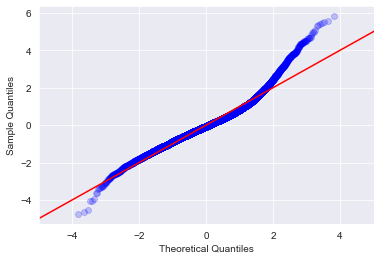

In [148]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_outliers.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [149]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_outliers.predict(X_train_norm)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_outliers.predict(X_test_norm)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Updated Model): ', round(((rmse_train-rmse_vanilla)/rmse_vanilla)*100, 3))


Train RMSE: 110300.26396984769 
 Test RMSE: 110613.70368385586
Percent change:  0.284
Percent change (Base Model vs. Updated Model):  -41.611


Adjusted R-squared improved by .003 to .836

RMSE decreased by 42.753% showing significant error reduction

### Model: Further Price Narrowing

In [150]:
upHouse_data_prim = upHouse_data_2std[upHouse_data_2std['price'] <= 790000]

In [151]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# # Add constants
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

training_model(feat_cols, outcome, y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     758.9
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:36:32   Log-Likelihood:            -1.6555e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12915   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.659e+04   9323.540     -7.142      0.000   -8.49e+04   -4.83e+04
bedrooms           -8.406e+04   1.03e+04     -8.150      0.000   -1.04e+05   -6.38e+04
sqft_living         3.682e+05    1.2e+04     30.588      0.000    3.45e+05    3.92e+05
floors              7.298e+04   5213.144     13.999      0.000    6.28e+04    8.32e+04
waterfront          8.725e+04   1.83e+04      4.771      0.000    5.14e+04    1.23e+05
view                 8.68e+04   5881.105     14.758      0.000    7.53e+04    9.83e+04
condition            8.34e+04   5203.844     16.027      0.000    7.32e+04    9.36e+04
grade               3.964e+05   1.04e+04     38.119      0.000    3.76e+05    4.17e+05
basement            7616.0048   1942.840      3.920      0.000    3807.752    1.14e+04
yr_built           -1.259e+05   5007.727    -25.136      0.000   -1.36e+05   -1.16e+05
renovated           1.194e+04   4877.249      2.448      0.014    2380.288    2.15e+04
lat                 2.766e+05   7051.894     39.217      0.000    2.63e+05     2.9e+05
long               -2.316e+05   2.24e+04    -10.360      0.000   -2.75e+05   -1.88e+05
sqft_living15       1.737e+05   9553.301     18.184      0.000    1.55e+05    1.92e+05
month               -2.06e+04   2646.494     -7.783      0.000   -2.58e+04   -1.54e+04
city_Bellevue       1.302e+05   6249.390     20.831      0.000    1.18e+05    1.42e+05
city_Black Diamond  1.406e+05   1.18e+04     11.887      0.000    1.17e+05    1.64e+05
city_Bothell       -5.802e+04   9803.067     -5.919      0.000   -7.72e+04   -3.88e+04
city_Carnation       4.15e+04   1.28e+04      3.250      0.001    1.65e+04    6.65e+04
city_Duvall        -3.268e+04    1.1e+04     -2.973      0.003   -5.42e+04   -1.11e+04
city_Enumclaw       1.099e+05   8661.153     12.694      0.000     9.3e+04    1.27e+05
city_Fall City      9.825e+04   1.49e+04      6.605      0.000    6.91e+04    1.27e+05
city_Federal Way   -4.663e+04   5483.589     -8.503      0.000   -5.74e+04   -3.59e+04
city_Issaquah       1.269e+05   7055.397     17.990      0.000    1.13e+05    1.41e+05
city_Kenmore       -7.714e+04   8631.606     -8.937      0.000   -9.41e+04   -6.02e+04
city_Kent           -1.36e+04   4658.074     -2.920      0.004   -2.27e+04   -4470.251
city_Kirkland       3.351e+04   6841.546      4.898      0.000    2.01e+04    4.69e+04
city_Maple Valley   5.488e+04   6516.619      8.422      0.000    4.21e+04    6.77e+04
city_Medina         3.963e+05   8.59e+04      4.614      0.000    2.28e+05    5.65e+05
city_Mercer Island  2.209e+05   1.31e+04     16.851      0.000    1.95e+05    2.47e+05
city_North Bend     1.274e+05   1.18e+04     10.816      0.000    1.04e+05    1.51e+05
city_Redmond        9.933e+04   7174.750     13.845      0.000    8.53e+04    1.13e+05
city_Renton         4630.5702   4812.8

In [152]:
model_prim = sm.OLS(y_train, X_train_norm).fit()

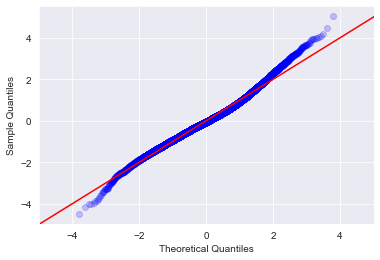

In [153]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_prim.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [272]:
# QQ Plot has heavy tails especially on the high-end. 
# Further trimming may be warranted. But first, let's work with what we got.

In [154]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim.predict(X_train_norm)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim.predict(X_test_norm)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-rmse_vanilla)/rmse_vanilla)*100, 3))


Train RMSE: 85556.90379606368 
 Test RMSE: 87245.36622062167
Percent change:  1.973
Percent change (Base Model vs. Model-Outliers Removed):  -53.815


Woah... that's better than I thought it would be. Slight decrease in R-squared but reduced error and close predictions between train and test sets.

Improved normalcy shown in QQ plot with further price trimming.

### Model: Interactions

In [155]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"


Testing 903 combinations.

R^2 including interaction of long and city_Seattle: 0.719


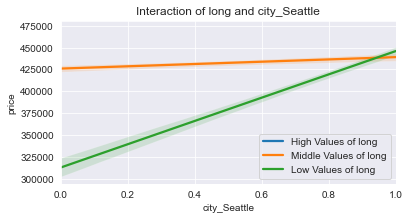

*********************

R^2 including interaction of lat and city_Kirkland: 0.717


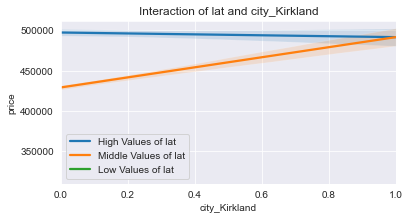

*********************

R^2 including interaction of yr_built and long: 0.716


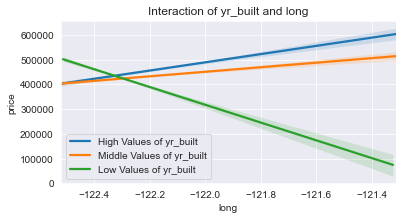

*********************

R^2 including interaction of yr_built and city_Seattle: 0.716


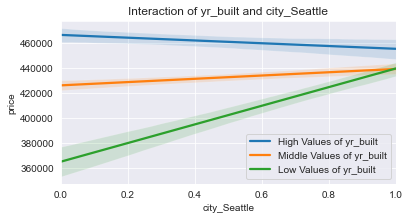

*********************

R^2 including interaction of grade and city_Seattle: 0.715


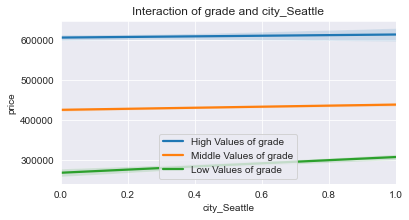

*********************

R^2 including interaction of sqft_living15 and city_Federal Way: 0.714


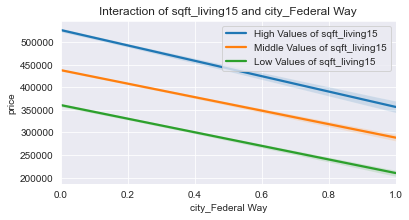

*********************

R^2 including interaction of sqft_living and lat: 0.714


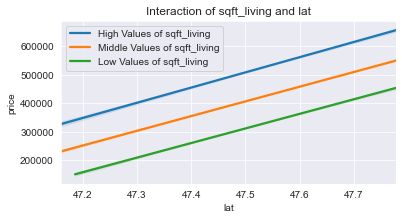

*********************

R^2 including interaction of sqft_living and basement: 0.714


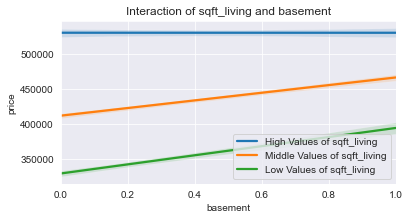

*********************

R^2 including interaction of long and city_Kent: 0.714


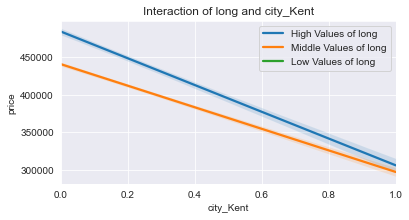

*********************

R^2 including interaction of grade and city_Federal Way: 0.714


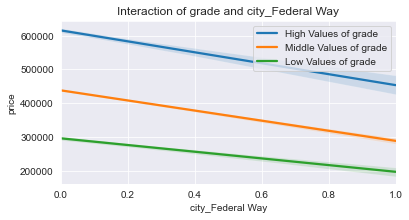

*********************

R^2 including interaction of basement and city_Seattle: 0.714


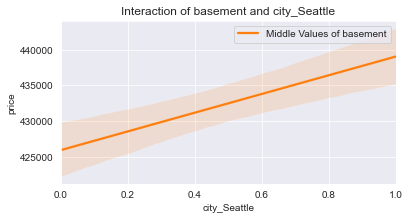

*********************

R^2 including interaction of sqft_living and yr_built: 0.713


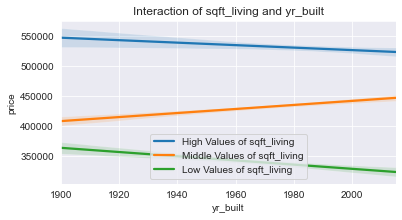

*********************

R^2 including interaction of sqft_living and view: 0.713


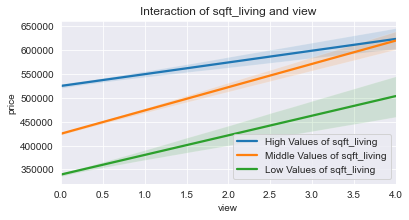

*********************

R^2 including interaction of sqft_living and sqft_living15: 0.713


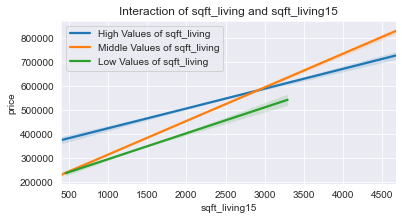

*********************

R^2 including interaction of sqft_living and floors: 0.713


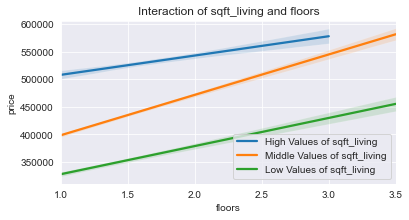

*********************



In [156]:
interactions = find_interactions(15, model_prim, X_train_norm)

In [157]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('yr_built', 'city_Seattle'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'basement'),
 ('long', 'city_Kent'),
 ('grade', 'city_Federal Way'),
 ('basement', 'city_Seattle'),
 ('sqft_living', 'yr_built'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15'),
 ('sqft_living', 'floors')]

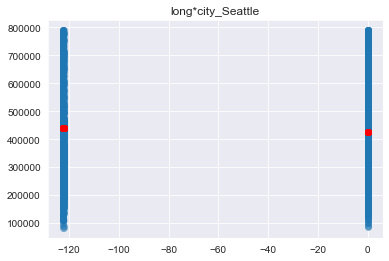

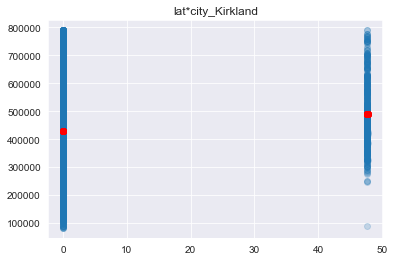

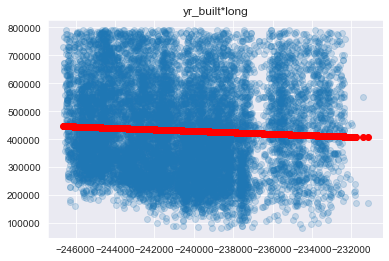

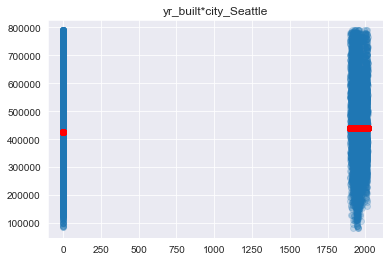

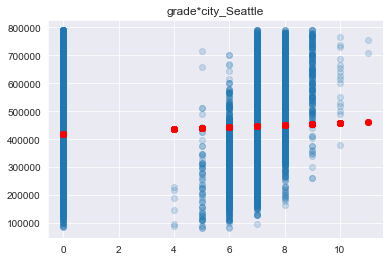

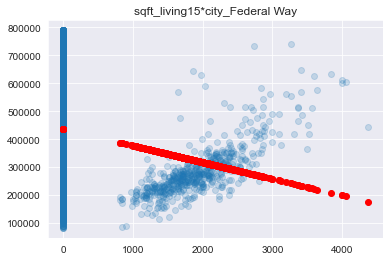

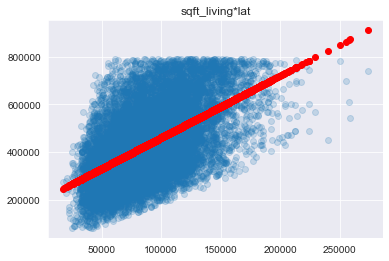

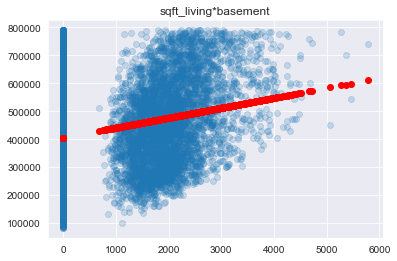

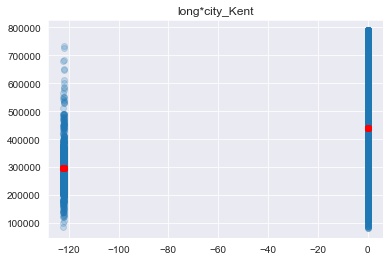

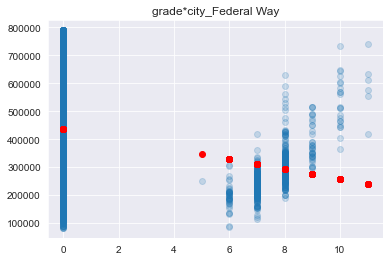

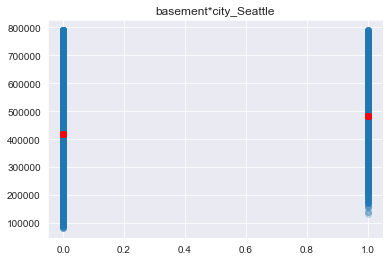

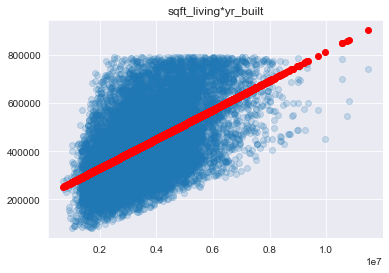

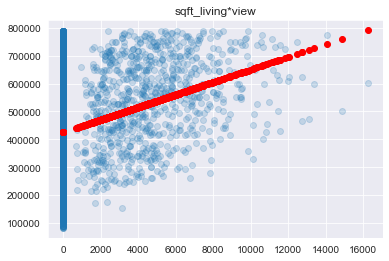

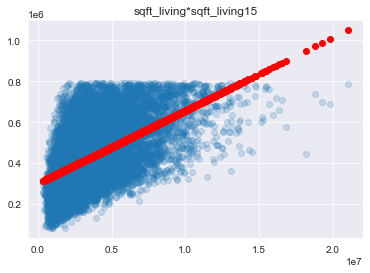

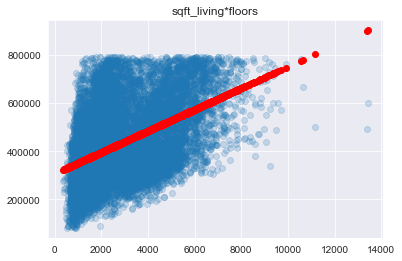

In [158]:
for inter in interactions:
    var = pd.DataFrame(X_train[inter[0]] * X_train[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    plt.scatter(var, y_train, alpha=.2)
    plt.scatter(var, y_pred, c='red')
    plt.title('{}*{}'.format(inter[0], inter[1]))
    plt.show()

In [361]:
remove = [('yr_built', 'long'),
          ('yr_built', 'city_Seattle')]
for inter in remove:
    interactions.remove(inter)

In [362]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'basement'),
 ('long', 'city_Kent'),
 ('grade', 'city_Federal Way'),
 ('basement', 'city_Seattle'),
 ('sqft_living', 'yr_built'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15'),
 ('sqft_living', 'floors')]

In [160]:
%run -i "functions/add_interactions.py"

In [161]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train_norm, X_test_norm)

Interaction Added: long * city_Seattle
Current R^2: 0.71881
Current Test MSE: 7365840046.5517
Current MSE Difference: -7365840045.83289

Interaction Added: yr_built * city_Seattle
Current R^2: 0.72204
Current Test MSE: 7262000663.2706
Current MSE Difference: -7262000662.54856

Interaction Added: grade * city_Seattle
Current R^2: 0.72948
Current Test MSE: 7072729566.01966
Current MSE Difference: -7072729565.29018

Interaction Added: sqft_living * basement
Current R^2: 0.7316
Current Test MSE: 7014818956.26676
Current MSE Difference: -7014818955.53516

Interaction Added: lat * city_Kirkland
Current R^2: 0.73529
Current Test MSE: 6866938475.55622
Current MSE Difference: -6866938474.82093

Interaction Added: sqft_living * lat
Current R^2: 0.7389
Current Test MSE: 6826836734.69164
Current MSE Difference: -6826836733.95274

Interaction Added: sqft_living * yr_built
Current R^2: 0.73982
Current Test MSE: 6787516439.23948
Current MSE Difference: -6787516438.49966

Interaction Added: sqft_livin

In [365]:
from sklearn.model_selection import cross_val_score
%run -i "functions/report.py"

In [162]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(feat_cols, outcome, y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     661.2
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:39:36   Log-Likelihood:            -1.6484e+05
No. Observations:               12958   AIC:                         3.298e+05
Df Residuals:                   12901   BIC:                         3.302e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -4.659e+04   1.67e+04     -2.787      0.005   -7.94e+04   -1.38e+04
bedrooms                         -8.357e+04   9926.118     -8.419      0.000   -1.03e+05   -6.41e+04
sqft_living                         2.1e+05   3.28e+04      6.397      0.000    1.46e+05    2.74e+05
floors                            5.789e+04   5079.559     11.397      0.000    4.79e+04    6.78e+04
waterfront                        7.527e+04   1.76e+04      4.266      0.000    4.07e+04     1.1e+05
view                              1.419e+05   1.42e+04     10.018      0.000    1.14e+05     1.7e+05
condition                         8.303e+04   4995.851     16.619      0.000    7.32e+04    9.28e+04
grade                             2.735e+05   1.24e+04     22.088      0.000    2.49e+05    2.98e+05
basement                          2.789e+04   5102.679      5.466      0.000    1.79e+04    3.79e+04
yr_built                         -1.176e+05   1.92e+04     -6.140      0.000   -1.55e+05   -8.01e+04
renovated                         1.343e+04   4653.214      2.886      0.004    4310.165    2.26e+04
lat                               2.164e+05   9567.232     22.623      0.000    1.98e+05    2.35e+05
long                             -9.834e+04   4.28e+04     -2.295      0.022   -1.82e+05   -1.44e+04
sqft_living15                     2.028e+05   1.71e+04     11.861      0.000    1.69e+05    2.36e+05
month                            -2.012e+04   2508.597     -8.021      0.000    -2.5e+04   -1.52e+04
city_Bellevue                     1.419e+05   6213.504     22.838      0.000     1.3e+05    1.54e+05
city_Black Diamond                1.034e+05   1.19e+04      8.654      0.000       8e+04    1.27e+05
city_Bothell                     -5.401e+04   9473.714     -5.701      0.000   -7.26e+04   -3.54e+04
city_Carnation                   -1.905e+04   1.37e+04     -1.388      0.165    -4.6e+04    7853.292
city_Duvall                       -8.57e+04   1.16e+04     -7.409      0.000   -1.08e+05    -6.3e+04
city_Enumclaw                      7.58e+04   9267.288      8.179      0.000    5.76e+04     9.4e+04
city_Fall City                    6.025e+04   1.53e+04      3.932      0.000    3.02e+04    9.03e+04
city_Federal Way                  4.886e+04   2.01e+04      2.434      0.015    9516.674    8.82e+04
city_Issaquah                     1.014e+05   7632.222     13.289      0.000    8.65e+04    1.16e+05
city_Kenmore                     -6.224e+04   8349.202     -7.455      0.000   -7.86e+04   -4.59e+04
city_Kent                        -9.267e+04    1.9e+04     -4.878      0.000    -1.3e+05   -5.54e+04
city_Kirkland                     1.571e+06   9.09e+04     17.290      0.000    1.39e+06    1.75e+06
city_Maple Valley                 1.431e+04   7118.68

In [164]:
model_int = sm.OLS(y_train, X_train2).fit()

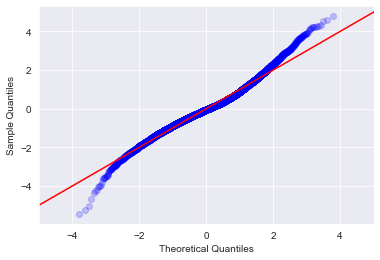

In [165]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [166]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_int.predict(X_train2)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_int.predict(X_test2)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-rmse_vanilla)/rmse_vanilla)*100, 3))


Train RMSE: 80991.61724483757 
 Test RMSE: 82144.64237078498
Percent change:  1.424
Percent change (Base Model vs. Model-Outliers Removed):  -56.515


In [393]:
# Adding interactions decreased RMSE and improved R-squared

### Model: Polynomial Features

In [167]:
%run -i "functions/get_polynomials.py"

Factor bedrooms by 2. R^2: 23837080334.60796


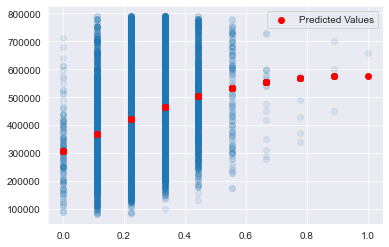

Factor sqft_living by 2. R^2: 18308245908.36213


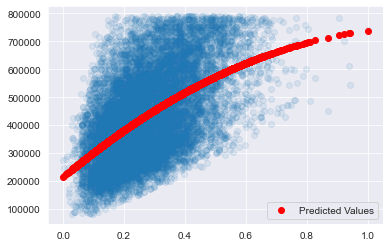

Factor floors by 2. R^2: 23617580764.78374


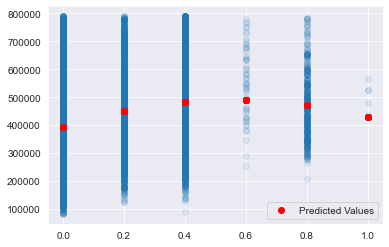

Factor view by 2. R^2: 24607279572.66134


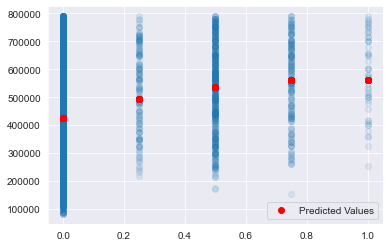

Factor condition by 2. R^2: 25361510683.37368


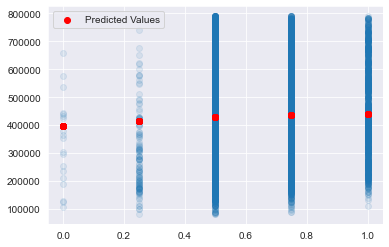

Factor grade by 2. R^2: 17820344420.42374


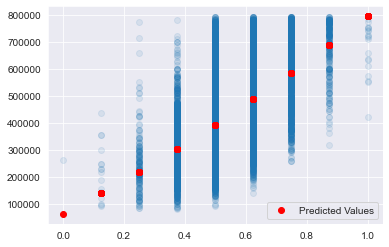

Factor yr_built by 2. R^2: 24394482490.64416


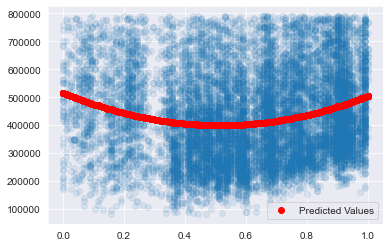

Factor lat by 2. R^2: 19333589905.36048


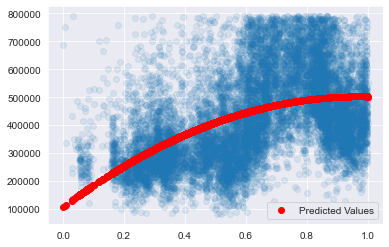

Factor long by 2. R^2: 25204603441.98104


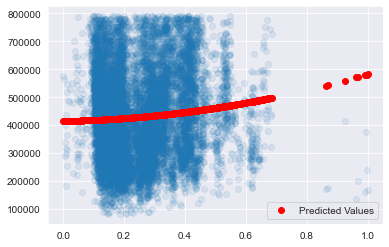

Factor sqft_living15 by 2. R^2: 19549262203.05532


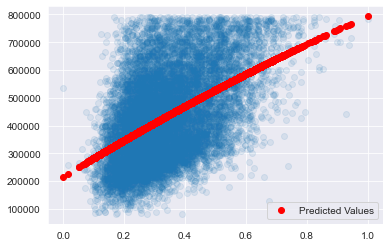

Factor month by 2. R^2: 25360068924.68963


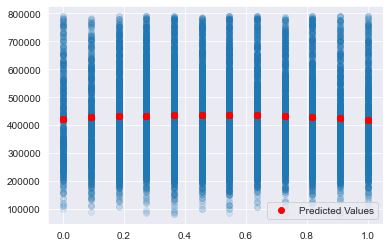

Factor city_Bellevue by 2. R^2: 24527726142.84702


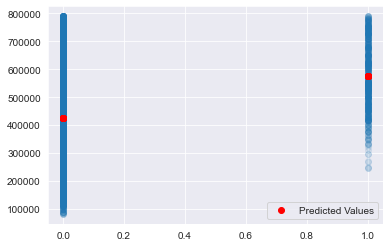

Factor long * city_Seattle by 2. R^2: 24991302414.24692


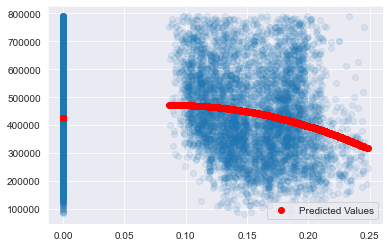

Factor yr_built * city_Seattle by 2. R^2: 25328365177.39194


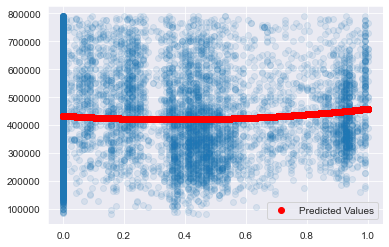

Factor grade * city_Seattle by 2. R^2: 23108103734.19218


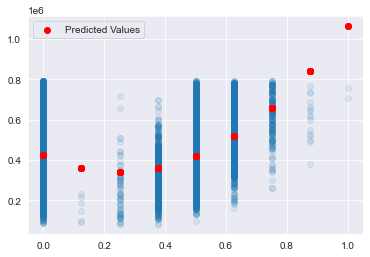

Factor sqft_living * basement by 2. R^2: 23627437186.28588


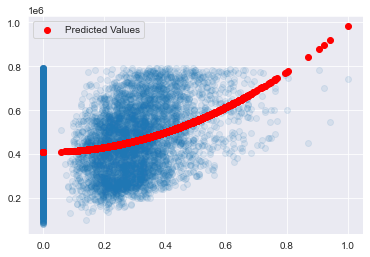

Factor lat * city_Kirkland by 2. R^2: 25050183132.18149


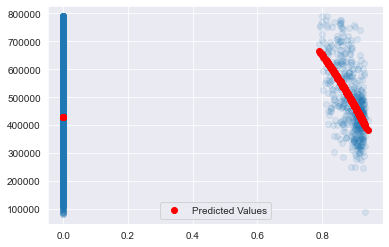

Factor sqft_living * lat by 2. R^2: 11808352939.15662


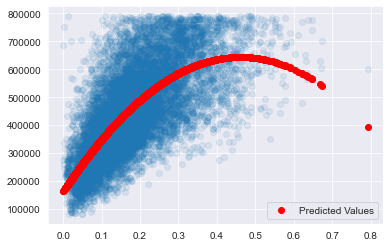

Factor sqft_living * yr_built by 2. R^2: 21631056582.5673


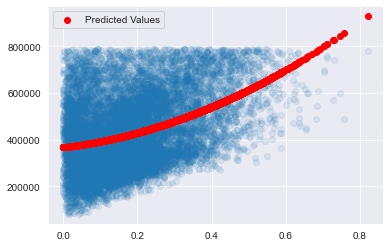

Factor sqft_living * view by 2. R^2: 24440330986.4258


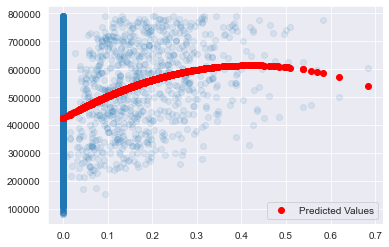

Factor grade * city_Federal Way by 2. R^2: 24235051238.96339


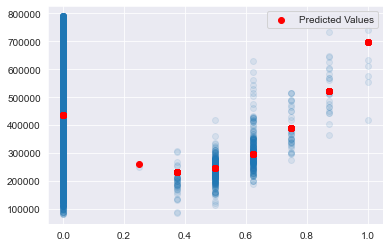

Factor long * city_Kent by 2. R^2: 24140845772.7277


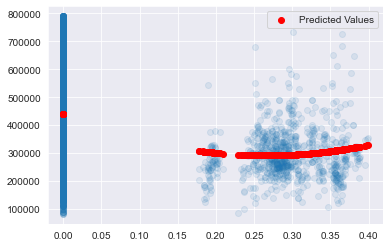

Factor sqft_living * sqft_living15 by 2. R^2: 18031787756.84694


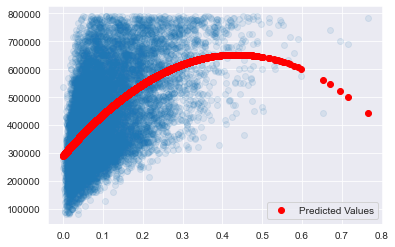

Factor sqft_living15 * city_Federal Way by 2. R^2: 24330690621.19644


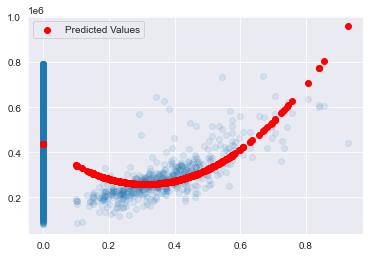

Factor yr_built * long by 2. R^2: 24705031901.9219


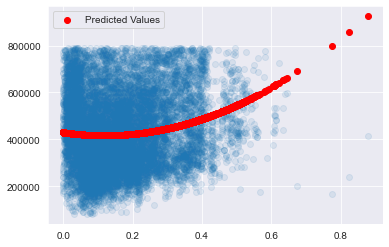

In [168]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 2)

In [169]:
poly_feat

[('bedrooms', 2),
 ('sqft_living', 2),
 ('floors', 2),
 ('view', 2),
 ('condition', 2),
 ('grade', 2),
 ('yr_built', 2),
 ('lat', 2),
 ('long', 2),
 ('sqft_living15', 2),
 ('month', 2),
 ('city_Bellevue', 2),
 ('long * city_Seattle', 2),
 ('yr_built * city_Seattle', 2),
 ('grade * city_Seattle', 2),
 ('sqft_living * basement', 2),
 ('lat * city_Kirkland', 2),
 ('sqft_living * lat', 2),
 ('sqft_living * yr_built', 2),
 ('sqft_living * view', 2),
 ('grade * city_Federal Way', 2),
 ('long * city_Kent', 2),
 ('sqft_living * sqft_living15', 2),
 ('sqft_living15 * city_Federal Way', 2),
 ('yr_built * long', 2)]

In [170]:
#Perform the same function as PolynomialFeatures, but name
# the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [171]:
X_train3 = sm.add_constant(X_train3)
X_test3 = sm.add_constant(X_test3)

In [172]:
model_poly = sm.OLS(y_train, X_train3).fit()

In [173]:
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     516.3
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:41:05   Log-Likelihood:            -1.6430e+05
No. Observations:               12958   AIC:                         3.288e+05
Df Residuals:                   12877   BIC:                         3.294e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.965e+05   3.25e+04     -6.038      0.000    -2.6e+05   -1.33e+05
bedrooms                           -5.668e+04   2.81e+04     -2.014      0.044   -1.12e+05   -1510.139
sqft_living                         1.292e+05    8.3e+04      1.557      0.120   -3.35e+04    2.92e+05
floors                              9422.8553   1.07e+04      0.883      0.377   -1.15e+04    3.03e+04
waterfront                          8.986e+04   1.86e+04      4.836      0.000    5.34e+04    1.26e+05
view                                3.533e+04    3.6e+04      0.981      0.327   -3.52e+04    1.06e+05
condition                           9.666e+04   2.95e+04      3.278      0.001    3.89e+04    1.54e+05
grade                              -1.887e+05   5.76e+04     -3.276      0.001   -3.02e+05   -7.58e+04
basement                            8454.5295   9036.247      0.936      0.349   -9257.854    2.62e+04
yr_built                            2895.8924   4.76e+04      0.061      0.951   -9.04e+04    9.62e+04
renovated                           1.713e+04   4486.240      3.817      0.000    8331.469    2.59e+04
lat                                 1.142e+06   4.91e+04     23.279      0.000    1.05e+06    1.24e+06
long                                1.982e+05   1.04e+05      1.906      0.057   -5647.501    4.02e+05
sqft_living15                       2.333e+05   4.08e+04      5.719      0.000    1.53e+05    3.13e+05
month                               -2.16e+04   9148.063     -2.361      0.018   -3.95e+04   -3667.613
city_Bellevue                      -1.165e+04   4471.832     -2.604      0.009   -2.04e+04   -2881.220
city_Black Diamond                  6.102e+04   1.18e+04      5.161      0.000    3.78e+04    8.42e+04
city_Bothell                       -1.633e+05   1.01e+04    -16.233      0.000   -1.83e+05   -1.44e+05
city_Carnation                      -1.76e+05   1.45e+04    -12.104      0.000   -2.05e+05   -1.48e+05
city_Duvall                        -2.145e+05   1.23e+04    -17.392      0.000   -2.39e+05    -1.9e+05
city_Enumclaw                       1.894e+05   1.05e+04     18.003      0.000    1.69e+05     2.1e+05
city_Fall City                     -1.096e+05   1.63e+04     -6.728      0.000   -1.42e+05   -7.77e+04
city_Federal Way                    8.043e+04   6.45e+04      1.246      0.213   -4.61e+04    2.07e+05
city_Issaquah                      -6.139e+04   9998.908     -6.139      0.000    -8.1e+04   -4.18e+04
city_Kenmore                       -1.701e+05   9074.631    -18.740      0.000   -1.88e+05   -1.52e+05
city_Kent                           1.153e+05   7.31e+04      1.578      0.115   -2.79e+04    2.59e+05
city_Kirkland                       6.257e+05   2.13e+06      0.294      0.769   -3.54e+06    4.

In [174]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_poly.predict(X_train3)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_poly.predict(X_test3)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-rmse_vanilla)/rmse_vanilla)*100, 3))


Train RMSE: 77673.28982011399 
 Test RMSE: 78813.53081602434
Percent change:  1.468
Percent change (Base Model vs. Model-Outliers Removed):  -58.279


In [175]:
linreg = LinearRegression()
model3 = linreg.fit(X_train3, y_train)

In [176]:
report(model3, X_train3, X_test3, 
       save_as='figures/Model_PolyResids.png')

NameError: name 'report' is not defined

### P-Value Filter

In [177]:
%run -i "functions/stepwise.py"

In [178]:
results = stepwise_selection(X_train3, y_train)
X_train4 = X_train3.loc[:,results]
X_test4 = X_test3.loc[:,results]
X = X.loc[:,results]

/Users/stephenenke/Documents/DSC-Project-2/Seattle-Housing-Regression-Analysis/functions/stepwise.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living * yr_built^2       with p-value 0.0
Add  sqft_living * lat              with p-value 0.0
Add  const                          with p-value 0.0
Add  grade^2                        with p-value 0.0
Add  sqft_living * lat^2            with p-value 7.47309e-208
Add  sqft_living * yr_built         with p-value 1.25011e-269
Add  view                           with p-value 2.05113e-94
Add  city_Bellevue^2                with p-value 6.20512e-98
Add  city_Bellevue                  with p-value 6.20512e-98
Add  city_Mercer Island             with p-value 1.20759e-53
Add  city_Issaquah                  with p-value 4.60389e-49
Add  city_Enumclaw                  with p-value 1.72877e-42
Add  city_Redmond                   with p-value 2.49815e-40
Add  grade * city_Seattle^2         with p-value 5.19511e-43
Add  sqft_living15                  with p-value 7.25619e-66
Add  long * city_Seattle^2          with p-value 5.64884e-77
Add  city_Sammamish                 with p-value 2.481

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [179]:
model_poly_step = sm.OLS(y_train, X_train4).fit()
model_poly_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     835.3
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:42:25   Log-Likelihood:            -1.6435e+05
No. Observations:               12958   AIC:                         3.288e+05
Df Residuals:                   12908   BIC:                         3.292e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
sqft_living * yr_built^2            2.852e+05   3.02e+04      9.438      0.000    2.26e+05    3.44e+05
sqft_living * lat                   5.532e+05   6.45e+04      8.581      0.000    4.27e+05     6.8e+05
const                              -8.516e+04   1.69e+04     -5.036      0.000   -1.18e+05    -5.2e+04
grade^2                             4.132e+05   4.02e+04     10.283      0.000    3.34e+05    4.92e+05
sqft_living * lat^2                -5.093e+05   7.73e+04     -6.590      0.000   -6.61e+05   -3.58e+05
view                                6.609e+04   1.82e+04      3.631      0.000    3.04e+04    1.02e+05
city_Bellevue^2                     2.126e+04   2192.070      9.701      0.000     1.7e+04    2.56e+04
city_Bellevue                       2.126e+04   2192.070      9.701      0.000     1.7e+04    2.56e+04
city_Mercer Island                  1.438e+05   1.17e+04     12.330      0.000    1.21e+05    1.67e+05
city_Issaquah                       1.725e+04   4378.357      3.940      0.000    8667.768    2.58e+04
city_Enumclaw                       2.023e+05   8508.202     23.779      0.000    1.86e+05    2.19e+05
grade * city_Seattle^2             -3.816e+05   6.13e+04     -6.226      0.000   -5.02e+05   -2.61e+05
sqft_living15                       1.831e+05   1.05e+04     17.384      0.000    1.62e+05    2.04e+05
long * city_Seattle^2               5.127e+06   6.79e+05      7.549      0.000     3.8e+06    6.46e+06
floors                              1.303e+04   4981.590      2.616      0.009    3264.897    2.28e+04
city_Kirkland                       6.663e+05   4.46e+04     14.929      0.000    5.79e+05    7.54e+05
lat * city_Kirkland^2              -8.955e+05   5.65e+04    -15.843      0.000   -1.01e+06   -7.85e+05
grade * city_Seattle                7.203e+05   6.36e+04     11.331      0.000    5.96e+05    8.45e+05
yr_built * city_Seattle              -3.6e+05   1.65e+04    -21.768      0.000   -3.92e+05   -3.28e+05
yr_built * city_Seattle^2           1.903e+05   1.62e+04     11.774      0.000    1.59e+05    2.22e+05
bedrooms                           -6.702e+04   9567.825     -7.005      0.000   -8.58e+04   -4.83e+04
city_Black Diamond                  1.087e+05      1e+04     10.833      0.000     8.9e+04    1.28e+05
lat                                 9.345e+05   3.23e+04     28.936      0.000    8.71e+05    9.98e+05
lat^2                              -5.466e+05   2.19e+04    -24.998      0.000   -5.89e+05   -5.04e+05
city_Duvall                        -1.326e+05   7536.757    -17.589      0.000   -1.47e+05   -1.18e+05
city_Renton                        -8.766e+04   3328.617    -26.335      0.000   -9.42e+04   -8.11e+04
city_Kent                          -1.254e+05   9404.994    -13.336      0.000   -1.44e+05   -1.

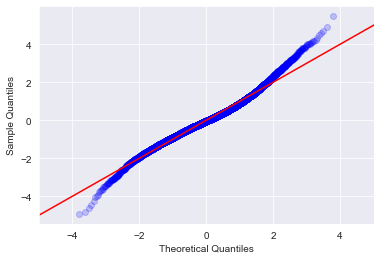

In [409]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_poly_step.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [180]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_poly_step.predict(X_train4)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_poly_step.predict(X_test4)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 78016.62286996786 
 Test RMSE: 78847.69439931805
Percent change:  1.065
Percent change (Base Model vs. Model-Outliers Removed):  -50.058


************
High Impact Variables:

Variable: lat^2
Coefficient: -1528612.6389377133

Variable: const
Coefficient: -2964967.032768715

Variable: city_Duvall
Coefficient: -141861.07837041235

Variable: city_Seattle
Coefficient: 63591735968.08842

Variable: long * city_Seattle
Coefficient: 1040115005.4418697

Variable: city_Kent
Coefficient: 28378781886.23365

************
************
Low Impact Variables:

Variable: sqft_living * basement^2
Coefficient: -0.001874854788184166

Variable: sqft_living * floors^2
Coefficient: -0.0023799110713298433

************

Train MSE: 6255167496.091594
Test MSE: 6565811450.473925
Difference:-310643954.3823309

Train R^2: 0.7535963041508685
Test R^2: 0.7405698112478901



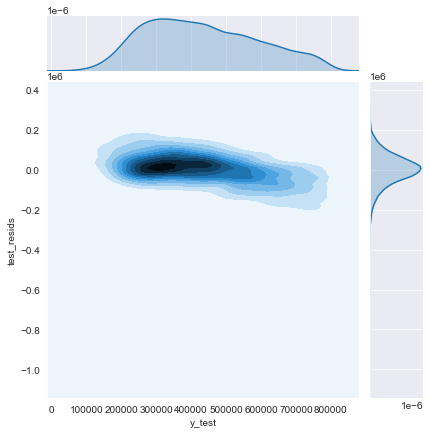

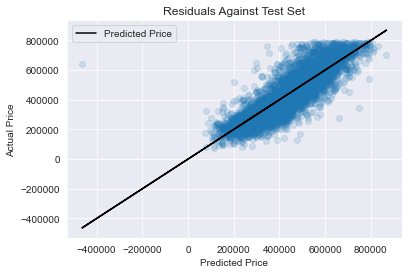

In [411]:
linreg = LinearRegression()
model4 = linreg.fit(X_train4, y_train)
report(model4, X_train4, X_test4, 
       save_as = 'figures/Model4Resids.png')

### Sklearn Feature Selector

In [194]:
len(X_train3.columns)

82

In [ ]:
from sklearn.feature_selection import RFE

In [195]:
#no of features
nof_list=np.arange(1,82)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train3,y_train)
    X_test_rfe = rfe.transform(X_test3)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=31 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=33 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=34 as keyword args. From version 0.25 passing thes

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=61 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=62 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=63 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=64 as keyword args. From version 0.25 passing thes

Optimum number of features: 81
Score with 81 features: 0.754611


In [234]:
cols = list(X_train3.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 81)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train3,y_train)  
#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['bedrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'basement', 'yr_built', 'renovated', 'lat', 'long',
       'sqft_living15', 'month', 'city_Bellevue', 'city_Black Diamond',
       'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Enumclaw',
       'city_Fall City', 'city_Federal Way', 'city_Issaquah', 'city_Kenmore',
       'city_Kent', 'city_Kirkland', 'city_Maple Valley', 'city_Medina',
       'city_Mercer Island', 'city_North Bend', 'city_Redmond', 'city_Renton',
       'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon',
       'city_Woodinville', 'bath_1', 'bath_2', 'bath_3', 'bath_4', 'bath_5',
       'long * city_Seattle', 'yr_built * city_Seattle',
       'grade * city_Seattle', 'sqft_living * basement', 'lat * city_Kirkland',
       'sqft_living * lat', 'sqft_living * yr_built', 'sqft_living * view',
       'grade * city_Federal Way', 'basement * city_Seattle',
       'long * city_Kent', 'sqft_living * sqft_livi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=81 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [235]:
model.score(X_rfe, y_train)

0.7623407402689477

In [208]:
rfe_cols = list(selected_features_rfe)

In [213]:
X_train3[rfe_cols]

,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,renovated,...,sqft_living * basement^2,lat * city_Kirkland^2,sqft_living * lat^2,sqft_living * yr_built^2,sqft_living * view^2,grade * city_Federal Way^2,long * city_Kent^2,sqft_living * sqft_living15^2,sqft_living15 * city_Federal Way^2,yr_built * long^2
6027,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,1.0,...,0.060572,0.0,0.027697,0.013855,0.0,0.00,0.000000,0.004950,0.000000,0.021137
19378,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,0.0,...,0.071995,0.0,0.068114,0.020926,0.0,0.00,0.000000,0.005138,0.000000,0.007238
9289,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,0.0,...,0.000000,0.0,0.013619,0.069929,0.0,0.00,0.000000,0.011193,0.000000,0.000008
6209,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,0.0,...,0.092099,0.0,0.083947,0.022626,0.0,0.00,0.000000,0.006120,0.000000,0.004558
4256,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,0.0,...,0.050135,0.0,0.035134,0.000307,0.0,0.00,0.000000,0.002486,0.000000,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,0.0,...,0.000000,0.0,0.252363,0.222558,0.0,0.00,0.000000,0.059285,0.000000,0.073575
18532,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,0.0,...,0.034931,0.0,0.026192,0.002538,0.0,0.00,0.000000,0.001881,0.000000,0.001926
7244,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,0.0,...,0.040684,0.0,0.005932,0.019688,0.0,0.00,0.074216,0.002235,0.000000,0.035915
10798,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,0.0,...,0.000000,0.0,0.001166,0.004060,0.0,0.25,0.000000,0.000771,0.051687,0.006220


In [215]:
X_train_rfe = X_train3[rfe_cols]
X_train_rfe = sm.add_constant(X_train_rfe)


In [217]:
X_train_rfe

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,sqft_living * basement^2,lat * city_Kirkland^2,sqft_living * lat^2,sqft_living * yr_built^2,sqft_living * view^2,grade * city_Federal Way^2,long * city_Kent^2,sqft_living * sqft_living15^2,sqft_living15 * city_Federal Way^2,yr_built * long^2
6027,1.0,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,...,0.060572,0.0,0.027697,0.013855,0.0,0.00,0.000000,0.004950,0.000000,0.021137
19378,1.0,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,...,0.071995,0.0,0.068114,0.020926,0.0,0.00,0.000000,0.005138,0.000000,0.007238
9289,1.0,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,...,0.000000,0.0,0.013619,0.069929,0.0,0.00,0.000000,0.011193,0.000000,0.000008
6209,1.0,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,...,0.092099,0.0,0.083947,0.022626,0.0,0.00,0.000000,0.006120,0.000000,0.004558
4256,1.0,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,...,0.050135,0.0,0.035134,0.000307,0.0,0.00,0.000000,0.002486,0.000000,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,1.0,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,...,0.000000,0.0,0.252363,0.222558,0.0,0.00,0.000000,0.059285,0.000000,0.073575
18532,1.0,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,...,0.034931,0.0,0.026192,0.002538,0.0,0.00,0.000000,0.001881,0.000000,0.001926
7244,1.0,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,...,0.040684,0.0,0.005932,0.019688,0.0,0.00,0.074216,0.002235,0.000000,0.035915
10798,1.0,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,...,0.000000,0.0,0.001166,0.004060,0.0,0.25,0.000000,0.000771,0.051687,0.006220


In [216]:
model_rfe = sm.OLS(X_train_rfe, y_train).fit()
model_rfe.summary()

ValueError: shapes (12958,82) and (12958,82) not aligned: 82 (dim 1) != 12958 (dim 0)

In [190]:
significant_features = RFE(X_train3, y_train)
# X_train_sig = pd.DataFrame(significant_features, columns = X_train3.columns)
print('Significant features:',len(X_train_sig.columns),'\nAll features:',len(X_train3.columns))

NameError: name 'X_train_sig' is not defined

In [82]:
house_data_2std = house_data[house_data['price'] <= 790000]

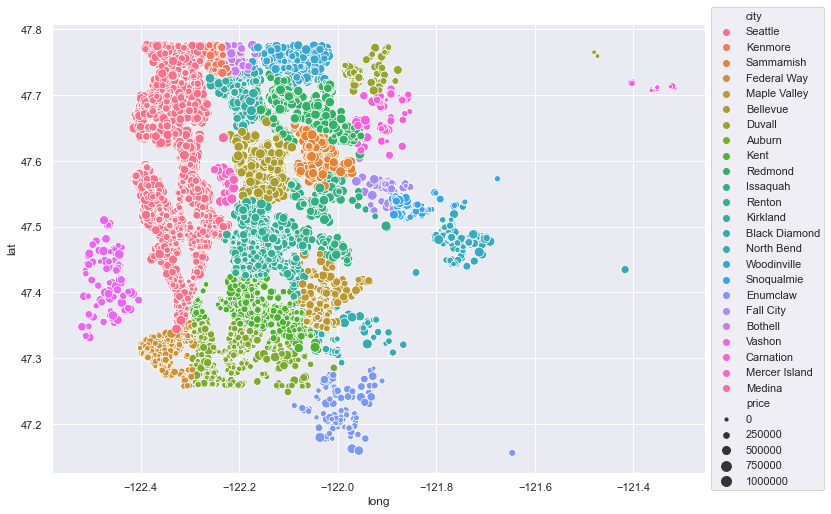

In [86]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(house_data_2std.long, house_data_2std.lat, hue=house_data_2std.city, size=house_data_2std.price,
    sizes=(10, 100))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

In [71]:
house_data['city']

0          Seattle
1          Seattle
2          Kenmore
3          Seattle
4        Sammamish
           ...    
21592      Seattle
21593      Seattle
21594      Seattle
21595     Issaquah
21596      Seattle
Name: city, Length: 21597, dtype: object

In [ ]:
# Our Real Estate focus is on houses $790,000 and under
# We can use the model to predict locations within the customer's price range
# If they are focused on an expensive area, we can help find adjacent cities to give them access nearby

In [ ]:
# As latitude increases (we move further north), prices increase generally

In [ ]:
# Kent, Kenmore, and Kirkland... that's unfortunate string of names